In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Custom Generator

In [2]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, img_dir, img_list, mask_dir, mask_list):
        self.img_dir = img_dir
        self.img_list = img_list
        self.mask_dir = mask_dir
        self.mask_list = mask_list

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.img_list[idx])
        mask_name = os.path.join(self.mask_dir, self.mask_list[idx])

        image = np.load(img_name)
        mask = np.load(mask_name)

        return torch.from_numpy(image), torch.from_numpy(mask)


def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
    dataset = CustomDataset(img_dir, img_list, mask_dir, mask_list)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

### testing generator

In [4]:
from torch import nn
from matplotlib import pyplot as plt
import random

4808
4808


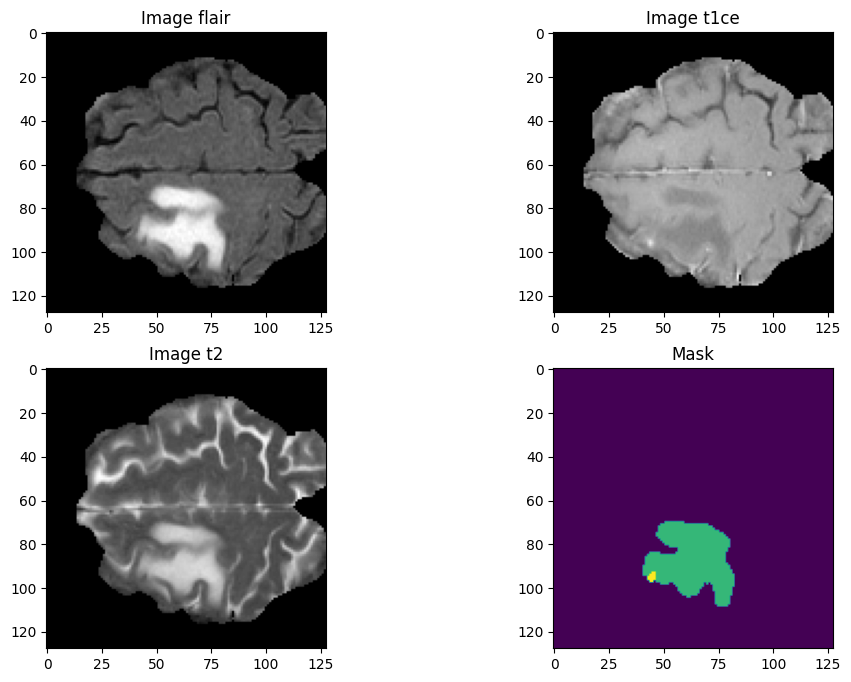

In [98]:
train_img_dir = "BraTS2021_TrainingData_2d/input_data_128/train/images/"
train_mask_dir = "BraTS2021_TrainingData_2d/input_data_128/train/masks/"

val_img_dir = "BraTS2021_TrainingData_2d/input_data_128/val/images/"
val_mask_dir = "BraTS2021_TrainingData_2d/input_data_128/val/masks/"

train_img_list= sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_list = sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))

print(len(train_img_list))
print(len(train_mask_list))

batch_size = 4

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator
for img, msk in train_img_datagen:
    break  # Break after the first batch

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=2)
#print(test_mask.shape) #--> torch.Size([128, 128])


#print(img.shape) #--> torch.Size([2, 128, 128, 3])
#print(test_img.shape) #--> torch.Size([128, 128, 3])

plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:])
plt.title('Mask')
plt.show()

In [8]:
print(len(train_img_datagen))  # :4
print(len(train_mask_list))

1202
4808


## deefinition of loss functions

In [9]:
class MultiClassDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(MultiClassDiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # inputs: [batch_size, num_classes, ...]
        # targets: [batch_size, num_classes, ...]

        dice_per_class = []
        for class_idx in range(inputs.size(1)):  # Iterate over classes
            class_inputs = inputs[:, class_idx, ...]
            #plt.imshow(class_inputs.detach().numpy()[:,70,:])
            class_targets = targets[:, class_idx, ...]

            # Compute Dice Loss for each class separately
            intersection = (class_inputs * class_targets).sum()
            dice = (2. * intersection + smooth) / (class_inputs.sum() + class_targets.sum() + smooth)
            dice_per_class.append(dice)

        # Average Dice Loss across all classes
        mean_dice_loss = torch.mean(torch.stack(dice_per_class))
        return 1 - mean_dice_loss


class MultiIoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(MultiIoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        IoU_per_class = []
        for class_idx in range(inputs.size(1)):
            class_inputs = inputs[:, class_idx, ...]
            class_targets = targets[:, class_idx, ...]

            intersection = (class_inputs * class_targets).sum() # True Positive count
            total = (class_inputs + class_targets).sum()
            union = total - intersection  # mutually inclusive area of all labels & predictions

            IoU = (intersection + smooth)/(union + smooth)
            IoU_per_class.append(IoU)

        mean_IoU_loss = torch.mean(torch.stack(IoU_per_class))

        return mean_IoU_loss  # will be used as accuracy --> reason why i don't do 1-blabla

In [12]:
import torch
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F

class conv2D_block(nn.Module):

    def __init__(self, in_ch, out_ch):

        super(conv2D_block, self).__init__()

        self.conv2D = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1), # no change in dimensions of 3D volume
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1), # no change in dimensions of 3D volume
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.3)
        )

    def forward(self, x):
        x = self.conv2D(x)
        return x

class up_conv2D_block(nn.Module):

    def __init__(self, in_ch, out_ch, scale_tuple):

        super(up_conv2D_block, self).__init__()

        self.up_conv2D = nn.Sequential(
            nn.Upsample(scale_factor=scale_tuple, mode='bilinear'),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1), # no change in dimensions of 3D volume
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True), # increasing the depth by adding one below
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1), # no change in dimensions of 3D volume
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.3)
        )

    def forward(self, x):
        x = self.up_conv2D(x)
        return x

class SA_UNet_8x8(nn.Module):

    def __init__(self, in_ch_SA=3, out_ch_SA=4):
        super(SA_UNet_8x8, self).__init__()

        filters_2D = [16, 16*2, 16*4, 16*8, 16*16, 16*16] # = [16, 32, 64, 128, 256, 512]

        self.Conv2D_1 = conv2D_block(in_ch_SA, filters_2D[0])
        self.Conv2D_2 = conv2D_block(filters_2D[0], filters_2D[1])
        self.Conv2D_3 = conv2D_block(filters_2D[1], filters_2D[2])
        self.Conv2D_4 = conv2D_block(filters_2D[2], filters_2D[3])
        self.Conv2D_5 = conv2D_block(filters_2D[3], filters_2D[4])
        self.Conv2D_6 = conv2D_block(filters_2D[4], filters_2D[5])

        self.MaxPool2D_1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.MaxPool2D_2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.MaxPool2D_3 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.MaxPool2D_4 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.MaxPool2D_5 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        self.up_Conv2D_1 = up_conv2D_block(filters_2D[5], filters_2D[4], (2,2))
        self.up_Conv2D_2 = up_conv2D_block(filters_2D[4]+filters_2D[4], filters_2D[3], (2,2))
        self.up_Conv2D_3 = up_conv2D_block(filters_2D[3]+filters_2D[3], filters_2D[2], (2,2))
        self.up_Conv2D_4 = up_conv2D_block(filters_2D[2]+filters_2D[2], filters_2D[1], (2,2))
        self.up_Conv2D_5 = up_conv2D_block(filters_2D[1]+filters_2D[1], filters_2D[0], (2,2))

        self.Conv2D_final = nn.Conv2d(filters_2D[0]+filters_2D[0], out_ch_SA, kernel_size=1, stride=1, padding=0)

    def forward(self, e_SA):

        # SA network's encoder
        e_SA_1 = self.Conv2D_1(e_SA)
        #print("E1:", e_SA_1.shape)
        e_SA = self.MaxPool2D_1(e_SA_1)
        #print("E2:", e_SA.shape)
        e_SA_2 = self.Conv2D_2(e_SA)
        #print("E3:", e_SA_2.shape)
        e_SA = self.MaxPool2D_2(e_SA_2)
        #print("E4:", e_SA.shape)
        e_SA_3 = self.Conv2D_3(e_SA)
        #print("E5:", e_SA_3.shape)
        e_SA = self.MaxPool2D_3(e_SA_3)
        #print("E6:", e_SA.shape)
        e_SA_4 = self.Conv2D_4(e_SA)
        #print("E7:", e_SA_4.shape)
        e_SA = self.MaxPool2D_4(e_SA_4)
        #print("E8:", e_SA.shape)
        e_SA_5 = self.Conv2D_5(e_SA)
        #print("E9:", e_SA_5.shape)
        e_SA = self.MaxPool2D_5(e_SA_5)
        #print("E10:", e_SA.shape)
        e_SA_6 = self.Conv2D_6(e_SA)

        del(e_SA)

        # SA network's decoder
        d_SA = self.up_Conv2D_1(e_SA_6)
        #print("E11:", e_SA_6.shape)
        #print("D1:", d_SA.shape)
        d_SA = torch.cat([e_SA_5, d_SA], dim=1)
        #print("D2:", d_SA.shape)
        d_SA = self.up_Conv2D_2(d_SA)
        #print("D3:", d_SA.shape)
        d_SA = torch.cat([e_SA_4, d_SA], dim=1)
        #print("D4:", d_SA.shape)
        d_SA = self.up_Conv2D_3(d_SA)
        #print("D5:", d_SA.shape)
        d_SA = torch.cat([e_SA_3, d_SA], dim=1)
        #print("D6:", d_SA.shape)
        d_SA = self.up_Conv2D_4(d_SA)
        #print("D7:", d_SA.shape)
        d_SA = torch.cat([e_SA_2, d_SA], dim=1)
        #print("D8:", d_SA.shape)
        d_SA = self.up_Conv2D_5(d_SA)
        #print("D9:", d_SA.shape)
        d_SA = torch.cat([e_SA_1, d_SA], dim=1)
        #print("D10:", d_SA.shape)
        d_SA = self.Conv2D_final(d_SA)
        #print("D11:", d_SA.shape)

        del(e_SA_1, e_SA_2, e_SA_3, e_SA_4, e_SA_5)
        d_SA = F.softmax(d_SA, dim=1)

        return d_SA

## Training

In [13]:
model = SA_UNet_8x8()

In [17]:
LR = 0.0001
NUM_EPOCHS = 25
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model.to(DEVICE)

multi_dice = MultiClassDiceLoss()
multi_IoU = MultiIoULoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

### training loop

In [18]:
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for images, masks in train_img_datagen:
        images = images.float().to(device=DEVICE)
        masks = masks.float().to(device=DEVICE)
        masks = torch.transpose(torch.transpose(masks, 1, -1), 2, -1)
        optimizer.zero_grad()
        preds = model(torch.transpose(torch.transpose(images, 1, -1), 2, -1))

        loss = multi_dice(preds,masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += multi_IoU(preds, masks).item()
        print("accuracy:", running_accuracy)

    epoch_loss = running_loss / len(train_img_datagen)
    epoch_accuracy = running_accuracy / len(train_img_datagen)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}:")
    print(f"  Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_accuracy:.4f}")

# Save the trained model
torch.save(model.state_dict(), 'models/brats_Unet2d.pth')

Output streaming troncato alle ultime 5000 righe.
accuracy: 687.955713301897
accuracy: 688.7392916977406
accuracy: 689.4472567141056
accuracy: 690.0943515598774
accuracy: 690.7084585726261
accuracy: 691.3173452913761
accuracy: 691.8201819956303
accuracy: 692.634936362505
accuracy: 693.4148835837841
accuracy: 694.0942238271236
accuracy: 694.5914561748505
accuracy: 695.4019913077354
accuracy: 696.2288309931755
accuracy: 696.8797033429146
accuracy: 697.68884152174
accuracy: 698.4576775431633
accuracy: 699.1042041182518
accuracy: 699.8082453012466
accuracy: 700.5706925988197
accuracy: 701.1442508101463
accuracy: 701.9030227661133
accuracy: 702.7531681060791
accuracy: 703.4443915486336
accuracy: 704.1198150515556
accuracy: 704.6464586257935
accuracy: 705.4250432252884
accuracy: 705.9170129299164
accuracy: 706.458302795887
accuracy: 707.1372264623642
accuracy: 707.8721673488617
accuracy: 708.6490774154663
accuracy: 709.3138610720634
accuracy: 710.0411263108253
accuracy: 710.6310167908669
acc

In [ ]:
modelLoad = SA_UNet_8x8()

modelLoad.load_state_dict(torch.load('models/brats_Unet2d.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

## Validation

###Validation on a single sample


In [ ]:
for imgs, msks in val_img_datagen:
    break

#print(imgs.shape, msks.shape) # --> torch.Size([batch_size, 128, 128, 128, 3]) torch.Size([batch_size, 128, 128, 128, 4])

img_num = random.randint(0, imgs.size(0)-1)
val_img = imgs[img_num].unsqueeze(0)
val_msk = msks[img_num].unsqueeze(0)

#print(val_img.shape, val_msk.shape) # --> torch.Size([1, 128, 128, 3]) torch.Size([1, 128, 128, 4])

In [ ]:
val_pred = model(torch.transpose(torch.transpose(torch.transpose(val_img.float(), 1, -1), 2, -1), 2, -2).to(device=DEVICE))
#print(val_pred.shape) # --> torch.Size([1, 4, 128, 128])

In [ ]:
val_pred = val_pred[0] # shape = torch.Size([4, 128, 128])

In [89]:
val_pred = torch.transpose(torch.transpose(val_pred, 0, -1), 0, 1) # shape = torch.Size([128, 128, 4])
val_msk = val_msk[0] # shape = torch.Size([128, 128, 4])

In [75]:
val_img = val_img[0]
val_img = val_img.cpu().numpy()

In [76]:
val_pred = val_pred.cpu().detach().numpy()
val_msk = val_msk.cpu().numpy()

val_msk=np.argmax(val_msk, axis=2)
val_pred = np.argmax(val_pred, axis=2)

In [77]:
val, counts = np.unique(val_pred, return_counts=True)
print('prediction', val, counts)

val, counts = np.unique(val_msk, return_counts=True)
print('mask', val, counts)

prediction [0 1 2 3] [14094   740  1022   528]
mask [0 1 2 3] [14457   757   607   563]


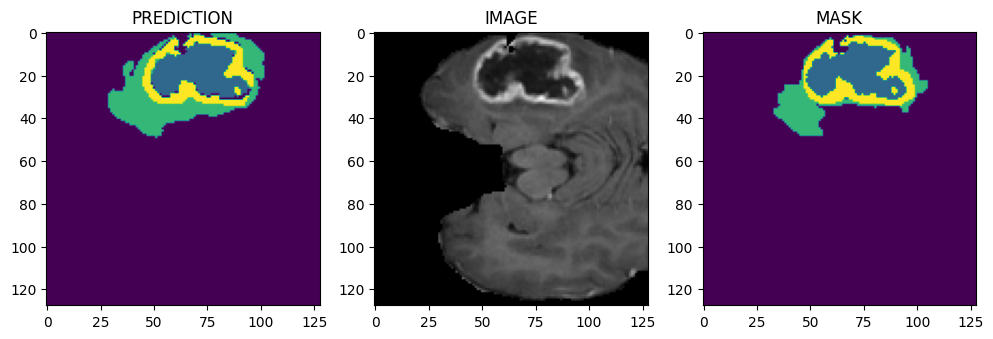

In [78]:
plt.figure(figsize=(12,6))

slice = 70

plt.subplot(131)
plt.title('PREDICTION')
plt.imshow(val_pred[:,:])
plt.subplot(132)
plt.title('IMAGE')
plt.imshow(val_img[:,:,1], cmap='gray')
plt.subplot(133)
plt.title('MASK')
plt.imshow(val_msk[:,:])

### Validation loop

In [ ]:
with torch.no_grad():
    test_loss = 0
    test_acc = 0

    for images, masks in val_img_datagen:
        images = images.float().to(device=DEVICE)
        masks = masks.float().to(device=DEVICE)
        masks = torch.transpose(torch.transpose(masks, 1, -1), 2, -1)

        preds = model(torch.transpose(torch.transpose(images, 1, -1), 2, -1))

        loss = multi_dice(preds,masks)
        print('loss',loss.item())

        test_loss += loss.item()

        test_acc += multi_IoU(preds, masks).item()
        print('accuracy', multi_IoU(preds, masks).item())

    test_loss /= len(val_img_datagen)
    test_acc /= len(val_img_datagen)

In [102]:
print('validation loss:', test_loss)
print('validation accuracy:', test_acc)

validation loss: 0.20930245251354584
validation accuracy: 0.6901156592408684
